In [1]:
import sys
# module_path = "/home/john-ubu/dev/minigrad"
module_path  ="C:\\Users\\mmonn\\Desktop\\torch\\pytorch_autrograd_reimplementation"
# Check if the module path is already in sys.path
if module_path not in sys.path:
    # Add the module path to sys.path
    sys.path.append(module_path)

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from ipywidgets import interact
from functools import partial
from src.utils import retain
%matplotlib inline

In [45]:
# define our quadratic function
def f(x):
    return 3*x**2 - 4*x + 5

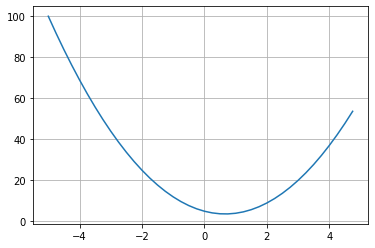

In [46]:
# plot the function
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.grid()

## Partial derivative w.r.t single variable

**definition of being differentiable**::
$${\displaystyle L=\lim _{h\to 0}{\frac {f(x+h)-f(x)}{h}}}$$

In other words,  it is the limit as `h` goes to 0 of
$${\frac {f(x+h)-f(x)}{h}}$$

**RQ**: What it's saying is if you're at some point `x` 
that you're interested in, and if you slightly increase it by
small number `h`, how does the function respond and with what sensitivity does it respond. So what we really want to know is what is the slope at that point; does the function go up or does it go down? and by how much? 

So we can basically evaluate the derivative here numerically by taking a very small `h`. Of course the definition would ask us to take an `h` value of 0 but we're just going to pick a very small `h`, let's say     0.001, and let's say we're interested in point 3.0. 
We look at `f(x)` for `x=3` and see the value is `20`. so if we nudge `x` by a very small amount `h`, how will the function respond?

In [44]:
# check derivate at x = 3 --> nugding up leads to increase in value
h = 0.0001
x = 3
slope = (f(x+h)-f(x))/h

print(f"The slope for f(x) at x = 3 is {slope :.3f}")

The slope for f(x) at x = 3 is 14.000


In [45]:
# check derivate at x = -3 --> nugding up leads to decrease in value
h = 0.0001
x = -3
slope = (f(x+h)-f(x))/h

print(f"The slope for f(x) at x = -3 is {slope:.3f}")

The slope for f(x) at x = -3 is -22.000


In [46]:
# check derivate at x = 2/3 --> nugding up leads to no change in value 
h = 0.0001
x = 2/3
slope = (f(x+h)-f(x))/h

print(f"The slope for f(x) at x = 2/3 is {slope:.3f}")

The slope for f(x) at x = 2/3 is 0.000


In [47]:
# Double check result w/ pytorch
# pour differentes valeures de x
x = torch.tensor([3.0,-3.0,2/3], requires_grad=True)
# pour une fonction f donnee  
y = 3*x**2 - 4*x + 5

gradients = torch.autograd.grad(y, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(x))
x1, x2, x3 = gradients[0]
print(f"The slope for f(x) at x = 3 is {x1:.3f}")
print(f"The slope for f(x) at x = -3 is {x2:.3f}")
print(f"The slope for f(x) at x = 2/3 is {x3:.3f}")

The slope for f(x) at x = 3 is 14.000
The slope for f(x) at x = -3 is -22.000
The slope for f(x) at x = 2/3 is 0.000


# Partial derivative w.r.t multiple variables

In order to evaluate this derivative we're going to get a bit hacky here:

 We're going to again have a very small value of `h` and then we're going to fix the inputs at some values that we're interested in (`a`,`b` and `c`).

After that we're going to be evaluating the the derivative of `d` with respect to `a`, `b` and `c` at that point. 

1. First we'll look at the derivative of `d` with respect to `a`; so we'll take `a`and we'll bump it by `h` and compare it to d2 which is the exact same function without the bump.

In [48]:
# our bump
h = 0.0001

# inputs at which we'll evaluate the derivative of d with respect to a, b and c.
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [49]:
# equation for d1 (adding h to a), so partial derivative of d with respect to a
d1 = a*b + c
a += h

# equation for d2 (without adding h to a)
d2 = a*b + c

print(f"d1 : {d1}")
print(f"d2 : {d2}")
# difference between d2 and d1, normalized by h, with respect to a
print(f"slope (gradient) with respect to a: {(d2-d1)/h:.3f}")

d1 : 4.0
d2 : 3.999699999999999
slope (gradient) with respect to a: -3.000


In [50]:
# equation for d1 (adding h to a), so partial derivative of d with respect to b
d1 = a*b + c
b += h

# equation for d2 (without adding h to b)
d2 = a*b + c

print(f"d1 : {d1}")
print(f"d2 : {d2}")
# difference between d2 and d1, normalized by h, with respect to b
print(f"slope (gradient) with respect to b: {(d2-d1)/h:.3f}")

d1 : 3.999699999999999
d2 : 3.99990001
slope (gradient) with respect to b: 2.000


In [51]:
# equation for d1 (adding h to a), so partial derivative of d with respect to c
d1 = a*b + c
c += h

# equation for d2 (without adding h to c)
d2 = a*b + c

print(f"d1 : {d1}")
print(f"d2 : {d2}")
# difference between d2 and d1, normalized by h, with respect to c
print(f"slope  (gradient) with respect to c : {(d2-d1)/h:.3f}")

d1 : 3.99990001
d2 : 4.00000001
slope  (gradient) with respect to c : 1.000


In [52]:
# Double check result w/ pytorch
a,b,c = torch.tensor([2.0,-3.0,10.0], requires_grad=True)
y = a*b + c
retain(a,b,c)
y.backward()
print(f"a.grad : {a.grad} || b.grad : {b.grad} || c.grad : {c.grad}")

a.grad : -3.0 || b.grad : 2.0 || c.grad : 1.0


However, we can't write out neural networks as mathematical expressions, they'd be monstrous, so instead what we're going to do is build a `Value Object`.

In [53]:
class Value:
    def __init__(self, data):
        self.data = data
    
    #  decide of the output string representation of data  
    # in human readable format 
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

In [54]:
a = Value(2.0)
a

Value(data=2.0)

In [55]:
# what if we want to add two Value objects?
a = Value(2.0)
b = Value(3.0)

try:
    c = a + b
    
except Exception as e:
    print(e)
    print(f"We have not implemented additions between two Value objects (yet!!)")

else:
    print(c)
    print("We have succesfully added two Value objects!!")

unsupported operand type(s) for +: 'Value' and 'Value'
We have not implemented additions between two Value objects (yet!!)


### Adding an __add__ method

In [56]:
class Value:
    def __init__(self, data):
        self.data = data
    
    #  decide of the output string representation of data   
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    # define addition
    def __add__(self, other):
        # creer un nouvel object Value qui contient la somme des deux
        summation = Value(self.data + other.data)
        return summation

In [57]:
# Now that we have added the __add__ method, we can add two Value objects.
a = Value(2.0)
b = Value(3.0)

try:
    c = a+b
except Exception as e:
    print(e)
    print(f"We have not implemented additions between two Value objects (yet!!)")

else:
    print(c)
    print("We have succesfully added two Value objects!!")

Value(data=5.0)
We have succesfully added two Value objects!!


### Adding a __mult__ method

In [58]:
# define multiplication
def __mul__(self, other):
    mult = Value(self.data * other.data)
    return mult

In [59]:
# monkey patch it to our Value class
Value.__mul__ = __mul__

In [60]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
print(a*b + c)
print((a.__mul__(b).__add__(c)))

Value(data=4.0)
Value(data=4.0)


# Putting the computational graph together

So now what we are missing is the connective tissue of this expression. We want to build a computational graph so we need to know and
keep pointers about what values produce what other values so here for example we are going to
introduce a new variable which we'll call `_children` and by default it will be an empty tuple. Then we will keep a
slightly different variable in the class which we'll call `_prev` which will be the set of `_children`.

In [139]:
class Value :

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        # tuple turned into set for efficiency
        self._prev = set(_children)
        # by default _op is the empty set for leaf nodes
        self._op = _op
  
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        # now we store the children in the new Value object to keep track of them on the computational graph
        # the children are the initial Value objects that were used to create the new Value object
        summation = Value(self.data + other.data, _children=(self, other), _op="+")
        return summation

    def __mul__(self, other):
        # now we store the children in the new Value object to keep track of them on the computational graph
        # the children are the initial Value objects that were used to create the new Value object
        mult = Value(self.data * other.data, _children=(self, other), _op="*")
        return mult


In [140]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b
e = d + c

In [141]:
print(f"Children : {d._prev} || Operation applied : {d._op}")
print(f"Children : {e._prev} || Operation applied : {e._op}")

Children : {Value(data=-3.0), Value(data=2.0)} || Operation applied : *
Children : {Value(data=-6.0), Value(data=10.0)} || Operation applied : +


## Visualizing the code

In [142]:
from graphviz import Digraph

In [143]:
class Value :

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        # tuple turned into set for efficiency
        self._prev = set(_children)
        # by default _op is the empty set for leaf nodes
        self._op = _op
        # _label is the label associated with the node
        self._label = _label
  
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        # now we store the children in the new Value object to keep track of them on the computational graph
        # the children are the initial Value objects that were used to create the new Value object
        summation = Value(self.data + other.data, _children=(self, other), _op="+")
        return summation

    def __mul__(self, other):
        # now we store the children in the new Value object to keep track of them on the computational graph
        # the children are the initial Value objects that were used to create the new Value object
        mult = Value(self.data * other.data, _children=(self, other), _op="*")
        return mult


In [144]:
def trace(root):
    # node: is the Value object being considered
    # edges : the two objects Value that created the node being considered
    nodes, edges = set(), set()
    def build(v):
        # prend initialement comme intrant le root node, puis
        # recursivement chaqune des child nodes
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                # la recursion se passe ici
                build(child)
                
    # Finalement on construit tous les nodes et edges ici
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
   
    nodes, edges = trace(root)
    
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f }" % (n._label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [145]:
a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')
e = a*b; e._label='e'
d = e + c; d._label ='d'
f = Value(-2.0, _label='f')
L = d * f; L._label = "L"

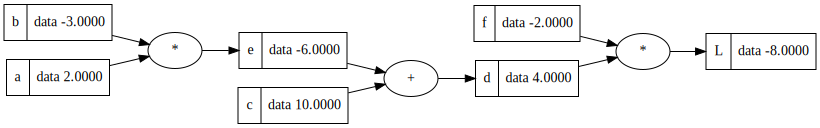

In [146]:
# visualize the result of a forward pass
draw_dot(L)

# Introducing backprop

In a neural network setting you'd be very interested in the derivative of  the loss function `L` with respect to the weights of a neural network. Here in our case we have the variables `a`, `b`, `c`, `d`, `e`, and `f` but they will eventually
represent the weights of a neural net and so we'll need to know how those weights are impacting the loss function. To do so we will need the derivative of the output with respect to `some` of its leaf nodes. Some of those leaf nodes will be the weights of the neural net, and the other leaf nodes will be the data itself but usually we will
not want or use the derivative of the loss function with respect to data because the data is fixed but the
weights will be iterated on using the gradient information.

So next we are going to create a variable inside the `Value` class that maintains the derivative of `L` with respect to that
value and we will call this variable `grad` so there's a `data` and there's a `self.grad`. Initially it will be zero (remember that a gradient of zero means it has no effect), so at initialization we're assuming that every value does not impact the
output (because if the gradient is zero, changing this variable is not changing the loss function).

In [147]:
import sys
# module_path = "/home/john-ubu/dev/minigrad"
module_path  ="C:\\Users\\mmonn\\Desktop\\torch\\pytorch_autrograd_reimplementation"
# Check if the module path is already in sys.path
if module_path not in sys.path:
    # Add the module path to sys.path
    sys.path.append(module_path)

In [148]:
import math
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
%matplotlib inline

In [1]:
class Value :

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        # adding grad and setting it to 0. Ca va track le partial derivativ 
        # of the output with respect to the value of the node being considered
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self._label = _label
  
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        summation = Value(self.data + other.data, _children=(self, other), _op="+")
        return summation

    def __mul__(self, other):
        mult = Value(self.data * other.data, _children=(self, other), _op="*")
        return mult


In [150]:
def trace(root):
    # node: is the Value object being considered
    # edges : the two objects Value that created the node being considered
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                # la recursion se passe ici
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
   
    nodes, edges = trace(root)
    
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = f"node : {n._label} | value = {n.data} | gradient = {n.grad}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [3]:
a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')
e = a*b; e._label='e'
d = e + c; d._label ='d'
f = Value(-2.0, _label='f')
L = d * f; L._label = "L"

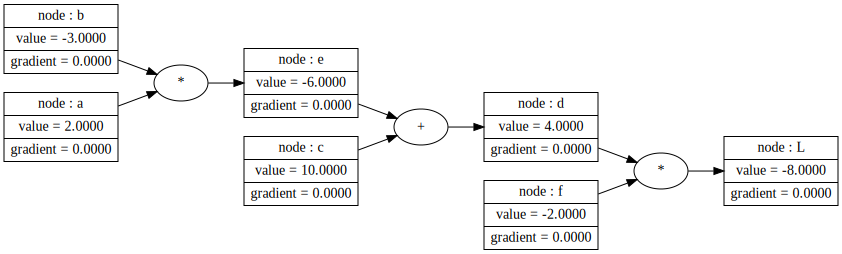

In [4]:
draw_dot(L)

In [31]:
def partial():
    """Calculating the derivative of L with respect to d"""
    h = 0.0001
    
    a = Value(2.0, _label='a')
    b = Value(-3.0, _label='b')
    c = Value(10.0, _label='c')
    e = a*b; e._label='e'
    d = e + c; d._label ='d'
    f = Value(-2.0, _label='f')
    L = d * f; L._label = "L"
    L1 = L.data
    
    # on ajoute `h` a notre Value `a`
    a = Value(2.0 , _label='a')
    b = Value(-3.0, _label='b')
    c = Value(10.0, _label='c')
    e = a*b; e._label='e'
    d = e + c ; d._label ='d'
    d.data +=h
    f = Value(-2.0, _label='f')
    L = d * f; L._label = "L"
    L2 = L.data
    
    # calcul de la derive partiel de L with respect to 'a'
    print((L2 - L1)/h)

In [32]:
partial()

-1.9999999999953388


We know that `L = d * f`, so what is `dL/dd?`? It is equal to `f`.

Here is the proof :

>Remember the equation for the derivative:
$$\frac{F(x+h)-F(x)}{h}$$

>So in our case:
$$\frac{dL}{dd}=\frac{(d+h)*f - (df)}{h}$$

>Which when expanded gives:
$$\frac{df + hf - df}{h} = \frac{ hf }{h} = f $$

So the derivative of `L` with respect to `d` is `f`. And we know by definition that `f` is a `Value object` with an associated scalar value (stored in the `.data` attribute) of `-2.0`. So `dL/dd = -2.0`.

Which is to say that the `gradient` of `d` with respect to `L` is `-2.0`.

We can apply the same process to find that the grad `gradient` of `f` with respect to `L` is `4`.

In [33]:
# store manualy the gradient
L.grad = 1
d.grad = -2
f.grad = 4

Now how do we obtain `dL/dc`? Lets break it down into two steps:
1. Find `dL/dd`
2. Find `dd/dc`
3. Apply the chain rule.

We already know `dL/dd` so now need `dd/dc`. We know that `d = c + e` so `dd/dc = 1`. We can reuse the demonstration from the previous cell to show `dd/dc = 1` for `d = c + e` 

>So in our case:

$$\frac{dd}{dc}=\frac{(c+h+e) - (c+e)}{h} = \frac{h}{h} = 1 $$

Now we just need to apply `the chain rule`, which definition can be found on wikipedia : 
The chain rule may also be expressed in Leibniz's notation. If a variable `z` depends on the variable `y`, which itself depends on the variable `x` (that is, `y` and `z` are dependent variables), then `z` depends on `x` as well, via the intermediate variable `y`. In this case, the chain rule is expressed as

$${\frac {dz}{dx}}={\frac {dz}{dy}}\cdot {\frac {dy}{dx}}$$

So what this tells us that we need to multiply the result of 1. with the result of 2., which means multiply :
$$\frac{dL}{dc} = \frac{dL}{dd}*\frac{dd}{dc} $$

We calculated in `1.` that `dL/dd = f` and in `2.` that `dd/dc = 1`, so `dL/dc = 1*f = f`.  

Which is to say that the `gradient` of `c` with respect to `L` is `-2.0`.

We can apply the same process to find that the grad `gradient` of `e` with respect to `L` is `2.0`. 

**RQ:** les operations d'additions ne font que propager le gradient, c'est pourquoi `c.grad == e.grad == d.grad`, car `d` provient d'une operation d'addition

In [34]:
c.grad = -2.0
e.grad = -2.0

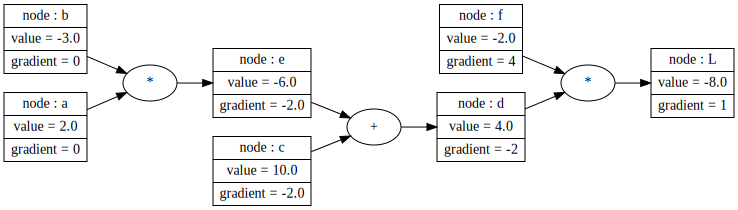

In [35]:
draw_dot(L)

Finalement pour trouver les gradient de `a` et `b` on prend la `derive locale` de `e` et on la multiplie par `de/db` pour obtenir `b.grad` et par `de/da` pour obtenir `a.grad`. (On reaplique recursivement la chaine rule a partir des derives locales).

1. `dL/de = -2.0`
2. `de/da` = `b` = -3.0 
3. `de/db` = `a` = 2.0 

> donc `dL/da` = `dL/de` * `de/da` = -2.0 * -3.0 = 6.0

> donc `dL/db` = `dL/de` * `de/db` = -2.0 * 2.0 = -4.0 

In [61]:
b.grad = -4.0
a.grad = 6.0

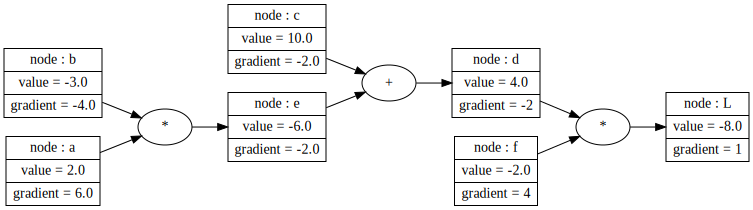

In [62]:
# la premiere backward pass est completee :)
draw_dot(L)

### Making our loss vary

In [ ]:
print(L.data)

In [66]:
# let's try to nudge our leaf nodes (a,b,c,f) to make our loss `L` go up.
# to do so we nudge our leaf nodes in the direction of the gradient (multiplied by a small number)
# because remember, the gradients we calculated are **local**; we dont want to overshoot
a.data += a.grad * 0.01
b.data += b.grad * 0.01
c.data += c.grad * 0.01
f.data += f.grad * 0.01

# run another forward pass after updating our gradients
e = a*b;
d = e + c; 
L = d * f; 

In [67]:
# We expected our Loss to go up, and it does.
print(L.data)

-7.215871776

# Backpropagating through a neuron
The last step we are missing is our activation function. Lets implement it and try it on a complete neuron example

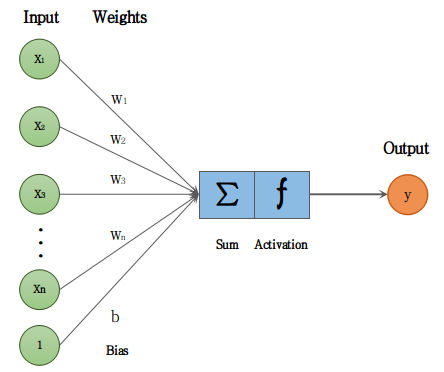

In [1]:
import sys
# module_path = "/home/john-ubu/dev/minigrad"
module_path  ="C:\\Users\\mmonn\\Desktop\\torch\\pytorch_autrograd_reimplementation"
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2
import math
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
from src.utils import draw_dot, trace
%matplotlib inline

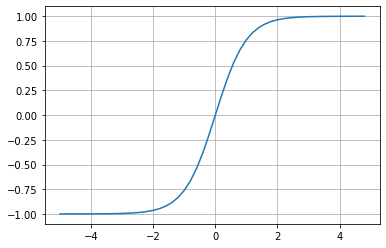

In [3]:
# activation function used to "squash" the neuron value.
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));
plt.grid()

So lets implement a tanh function, who's definition is as follows : 
\begin{equation}
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{e^{2x} - 1}{e^{2x} + 1}
\end{equation}

In [4]:
class Value :

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self._label = _label
  
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        summation = Value(self.data + other.data, _children=(self, other), _op="+")
        return summation

    def __mul__(self, other):
        mult = Value(self.data * other.data, _children=(self, other), _op="*")
        return mult
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        # since the operation is on itself, and from itself, the _children tuple is only self.
        out = Value(t, _children=(self,), _op='tanh')
        return out

In [5]:
# neuron example
# create features x1, x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

# create corresponding weights w1, w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias
b = Value(6.8813735870195432, _label='bias')

# feature * weight interaction
x1w1 = x1 * w1; x1w1._label = 'x1*w1'
x2w2 = x2 * w2; x2w2._label = 'x2*w2'

# sum
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2._label = 'x1*w1 + x2*w2'

# add bias to obtain final neuron
n = x1w1_x2w2 + b; n._label = 'n'

# activation (we dont have one yet...)
o = n.tanh(); o._label = 'o'

In [6]:
o.__dict__

{'data': 0.7071067811865476,
 'grad': 0,
 '_prev': {Value(data=0.8813735870195432)},
 '_op': 'tanh',
 '_label': 'o'}

In [7]:
# what we care for specificaly in neural networks is the gradient of the leaf node weights.
# the value of the features are given, we cannot change them, but we can learn the weights.
# so here what we really care about is do/dw1 and do/dw2.
# first off we know do/do = 1
o.grad = 1.0

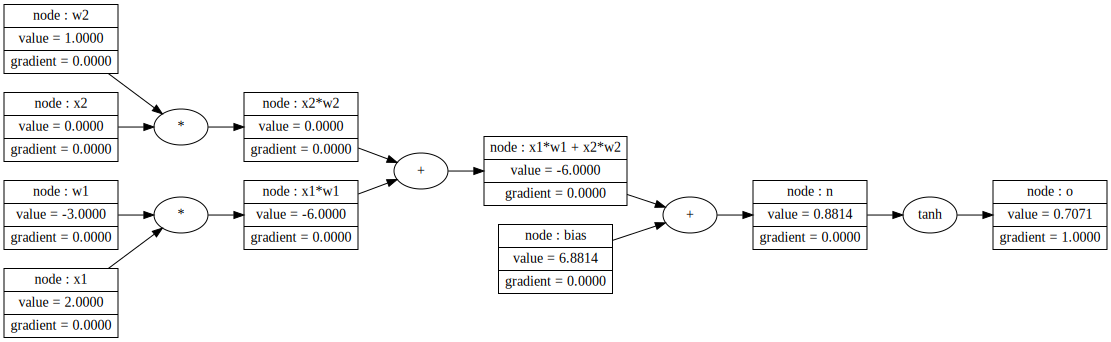

In [8]:
draw_dot(o)

The derivative of tanh is as follows : 
$$\frac{d}{dx}\tanh(x) = 1 - \tanh^2(x)$$

to be read as 1 minus ((tanh of x) squared). 

In [9]:
# o = tanh(n)
# do/dn = 1 - ((tanh(n))**2) and we know from the previous line that tanh(n) = o
# D'ou on retombe sur 1 - ((tanh(n))**2) = 1 - o**2
# So the gradient of n is 1 - o**2
print(f"The gradient of n is : {1-o.data**2}")

The gradient of n is : 0.4999999999999999


In [10]:
# we round the gradient to 0.5 to have clean outputs
n.grad = 1-o.data**2
# Since the node n results from an addition operation,
# the gradient simply flows through to the children nodes
b.grad = n.grad
x1w1_x2w2.grad = n.grad
x2w2.grad = n.grad
x1w1.grad = n.grad

In [11]:
# and the final nodes are multiplication nodes so
# we know how to easily obtain them by now
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

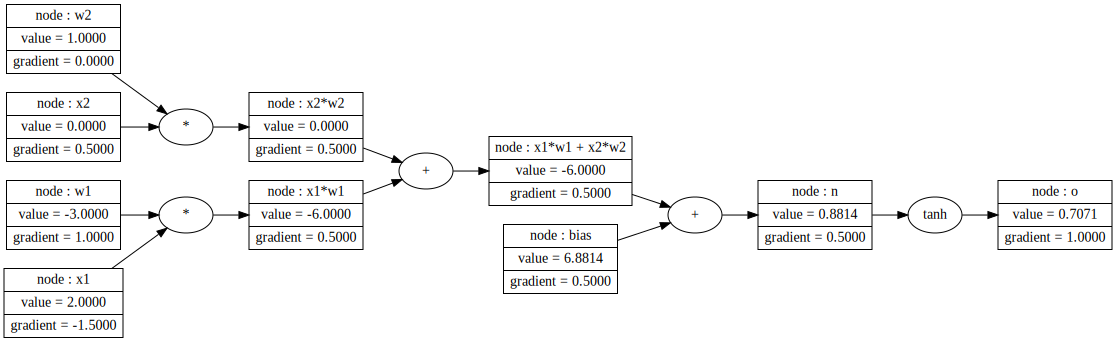

In [12]:
# good question by now : Why is w2 gradient 0? Answer : because x2 value is 0, so nudging w2 has no effect.
draw_dot(o)

# Automating Backpropagation

In [9]:
import sys
# module_path = "/home/john-ubu/dev/minigrad"
module_path  ="C:\\Users\\mmonn\\Desktop\\torch\\pytorch_autrograd_reimplementation"
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2
import math
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
from src.utils import draw_dot, trace
%matplotlib inline

In [11]:
class Value :

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self._label = _label
        # implementing the chain rule (defaults to None for leaf nodes)
        self._backward = lambda : None
  
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        summation = Value(self.data + other.data, _children=(self, other), _op="+")
        
        def _backward():
            self.grad = 1.0 * summation.grad
            other.grad = 1.0 * summation.grad
            
        summation._backward = _backward    
        return summation

    def __mul__(self, other):
        mult = Value(self.data * other.data, _children=(self, other), _op="*")
        
        def _backward():
            self.grad = other.data * mult.grad
            other.grad = self.data * mult.grad
            
        mult._backward = _backward
        return mult
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op='tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad # out.grad should always be 1 since do/do = 1?
        
        out._backward = _backward
        return out
    
    

In [12]:
# neuron example
# create features x1, x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

# create corresponding weights w1, w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias
b = Value(6.8813735870195432, _label='bias')

# feature * weight interaction
x1w1 = x1 * w1; x1w1._label = 'x1*w1'
x2w2 = x2 * w2; x2w2._label = 'x2*w2'

# sum
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2._label = 'x1*w1 + x2*w2'

# add bias to obtain final neuron
n = x1w1_x2w2 + b; n._label = 'n'

# activation (we dont have one yet...)
o = n.tanh(); o._label = 'o'

In [13]:
# backprob time.
# CAREFULL, because all gradients are initialized at 0
# and the backward of tanh is multiplied by out.grad.
# Therefore as a base case we must initialize o.grad to 1
o.grad = 1

In [6]:
o._backward()
n._backward()
b._backward()
x1w1_x2w2._backward()
x1w1._backward()
x2w2._backward()

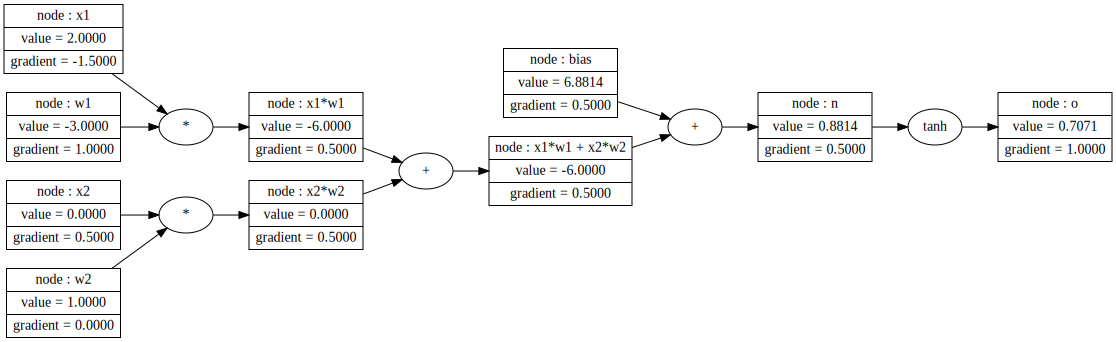

In [7]:
draw_dot(o)

# Using a topological sort
>A laying out of the nodes such that all of the edges go only in one direction

In [30]:
topo = []
# we maintain a log of visited nodes
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        # important : on append only once all 
        # the children have been built recursivly (previous line of code)
        # this ensure the node is only in the list once its children have been added
        topo.append(v)

build_topo(o)
# retourne les nodes de gauche a droite dans l'ordre, en commancant par la branche 
# sur la partie superieure du graph
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [31]:
# On a maintenant un topolical sort allant des leafs jusqu'au root. Pour apply la backprob on veut cependant aller
# de root jusqu'aux leafs, so we inverse our topological sort results to obtain the result we desire in order d'etre capable
# d'appliquer la backprop DEPUIS le root JUSQU'AUX leafs.
for node in reversed(topo):
    node._backward()

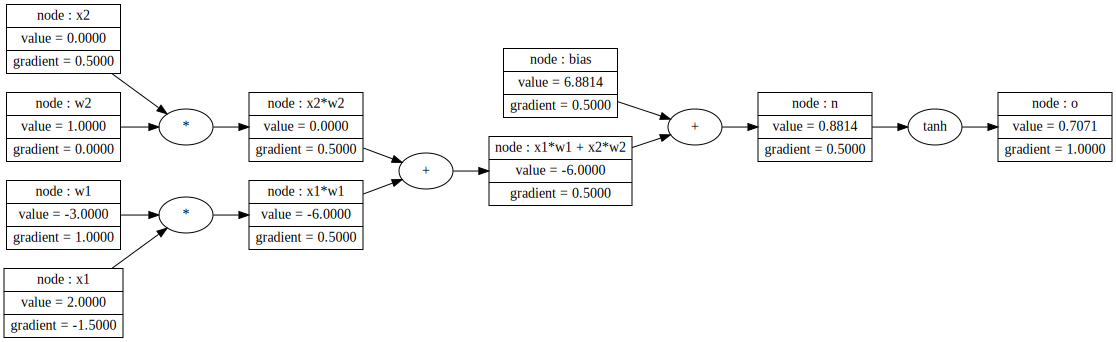

In [32]:
draw_dot(o)

# Refactor the Value class to automate backprob

In [33]:
class Value :

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self._label = _label
        # implementing the chain rule (defaults to None for leaf nodes)
        self._backward = lambda : None
  
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        summation = Value(self.data + other.data, _children=(self, other), _op="+")
        
        def _backward():
            # ATTENTION += to allow gradients to accumulate and not be
            # overwritten during backward. This comment is valid for mult and tanh as well.
            self.grad += 1.0 * summation.grad
            other.grad += 1.0 * summation.grad
            
        summation._backward = _backward    
        return summation

    def __mul__(self, other):
        mult = Value(self.data * other.data, _children=(self, other), _op="*")
        
        def _backward():
            self.grad += other.data * mult.grad
            other.grad += self.data * mult.grad
            
        mult._backward = _backward
        return mult
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op='tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad # out.grad should always be 1 since do/do = 1?
        
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        # we maintain a log of visited nodes
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                # important : on append only once all 
                # the children have been built recursivly (previous line of code)
                # this ensure the node is only in the list once its children have been added
                topo.append(v)
                
        # this sets off backward by calling build_topo to self
        build_topo(self)
        topo
       
        # CAREFULL, because all gradients are initialized at 0
        # and the backward of tanh is multiplied by out.grad.
        # Therefore as a base case we must initialize o.grad to 1
        self.grad = 1
        for node in reversed(topo):
            node._backward()
    

In [34]:
# neuron example
# create features x1, x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

# create corresponding weights w1, w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias
b = Value(6.8813735870195432, _label='bias')

# feature * weight interaction
x1w1 = x1 * w1; x1w1._label = 'x1*w1'
x2w2 = x2 * w2; x2w2._label = 'x2*w2'

# sum
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2._label = 'x1*w1 + x2*w2'

# add bias to obtain final neuron
n = x1w1_x2w2 + b; n._label = 'n'

# activation function
o = n.tanh(); o._label = 'o'

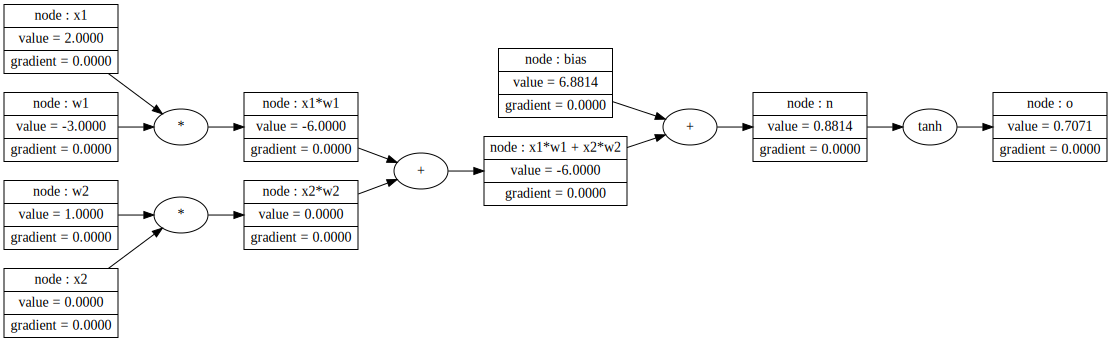

In [35]:
draw_dot(o)

In [36]:
o.backward()

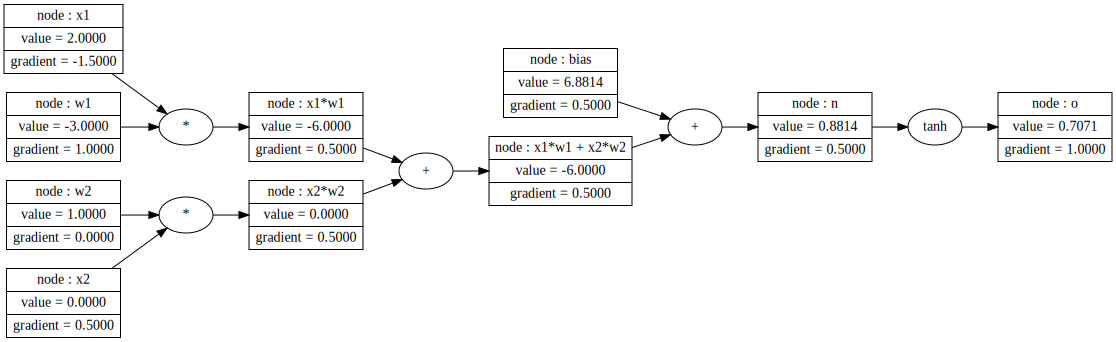

In [37]:
draw_dot(o)

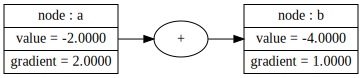

In [39]:
# testing edge case
a = Value(-2.0, _label='a')
b = a + a; b._label = 'b'
b.backward()
draw_dot(b)

## Extra steps : breaking down Tanh to its atomic components

Introducing **\__rmul__** : https://www.geeksforgeeks.org/__rmul__-in-python/

and **\__radd__** : https://stackoverflow.com/questions/9126766/addition-between-classes-using-radd-method

In [35]:
import sys
# module_path = "/home/john-ubu/dev/minigrad"
module_path  ="C:\\Users\\mmonn\\Desktop\\torch\\pytorch_autrograd_reimplementation"
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2
import math
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
from src.utils import draw_dot, trace
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we are going to add :
- **\__rmul__**
- **\__radd__**
- add the isinstance functionality to \__add__ and \__mul__ to be able to add/multiply Value objects with ints and floats
- add `exp` operation
- add `pow` operation
- add **\__truediv__** operation

Detailed explanations can be found here : 
- https://python-course.eu/oop/magic-methods.php
- https://blog.finxter.com/python-__neg__-magic-method/

In [41]:
class Value :

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self._label = _label
        # implementing the chain rule (defaults to None for leaf nodes)
        self._backward = lambda : None
  
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        # next line of code added to be able to add integers to Value objects
        other = other if isinstance(other, Value) else Value(other)
        summation = Value(self.data + other.data, _children=(self, other), _op="+")
        
        def _backward():
            # ATTENTION += to allow gradients to accumulate and not be
            # overwritten during backward. This comment is valid for mult and tanh as well.
            self.grad += 1.0 * summation.grad
            other.grad += 1.0 * summation.grad
            
        summation._backward = _backward    
        return summation
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
        
        
    def __mul__(self, other):
        # next line of code added to be able to add integers to Value objects
        other = other if isinstance(other, Value) else Value(other)
        mult = Value(self.data * other.data, _children=(self, other), _op="*")
        
        def _backward():
            self.grad += other.data * mult.grad
            other.grad += self.data * mult.grad
            
        mult._backward = _backward
        return mult
  
    # defining __rmul__ as a fallback for multiplication. When other is an int Value * int works
    # but int * Value doesnt. To bypass this we need __rmul__ to tell __mul__ what to fall back to
    # And what it does is switch the order of operations back to Value * int
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)) # only support int and float powers
        out = Value(self.data**other, _children=(self,), _op=f"**{other}")
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    # define exponential in order to be able to re-build tanh
    def exp(self):
        x = self.data
        out = Value(math.exp(x), _children=(self,), _op='exp')
        
        def _backward():
            self.grad = out.data * out.grad
        
        out._backward = _backward
        return out
    

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op='tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad # out.grad should always be 1 since do/do = 1?
        
        out._backward = _backward
        return out
    

    
    def backward(self):
        topo = []
        # we maintain a log of visited nodes
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                # important : on append only once all 
                # the children have been built recursivly (previous line of code)
                # this ensure the node is only in the list once its children have been added
                topo.append(v)
                
        # this sets off backward by calling build_topo to self
        build_topo(self)
        topo
       
        # CAREFULL, because all gradients are initialized at 0
        # and the backward of tanh is multiplied by out.grad.
        # Therefore as a base case we must initialize o.grad to 1
        self.grad = 1
        for node in reversed(topo):
            node._backward()
    

In [42]:
# Now use the new methods we created. Should obtain same results, same gradients, for each node
# neuron example
# create features x1, x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

# create corresponding weights w1, w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias
b = Value(6.8813735870195432, _label='bias')

# feature * weight interaction
x1w1 = x1 * w1; x1w1._label = 'x1*w1'
x2w2 = x2 * w2; x2w2._label = 'x2*w2'

# sum
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2._label = 'x1*w1 + x2*w2'

# add bias to obtain final neuron
n = x1w1_x2w2 + b; n._label = 'n'

# ------
#multiplicative 2 automaticaly becomes a Value object because of the __mult__ properties
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ------
e._label = "e"
o._label = "o"
# ------
o.backward()

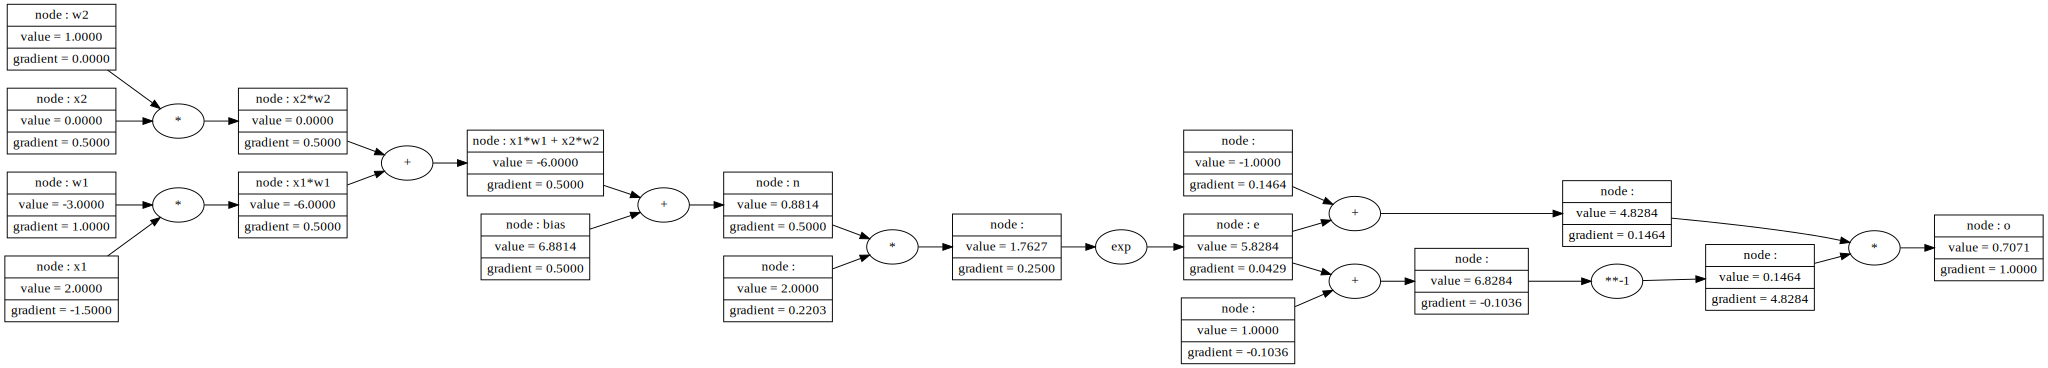

In [43]:
draw_dot(o)

# Final Value class

In [4]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op 
        self._label=_label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)) 
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [66]:
# Now use the new methods we created. Should obtain same results, same gradients, for each node
# neuron example
# create features x1, x2
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

# create corresponding weights w1, w2
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias
b = Value(6.8813735870195432, _label='bias')

# feature * weight interaction
x1w1 = x1 * w1; x1w1._label = 'x1*w1'
x2w2 = x2 * w2; x2w2._label = 'x2*w2'

# sum
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2._label = 'x1*w1 + x2*w2'

# add bias to obtain final neuron
n = x1w1_x2w2 + b; n._label = 'n'

# ------
#multiplicative 2 automaticaly becomes a Value object because of the __mult__ properties
o = n.relu()
# ------
o._label = "o"
# ------
o.backward()

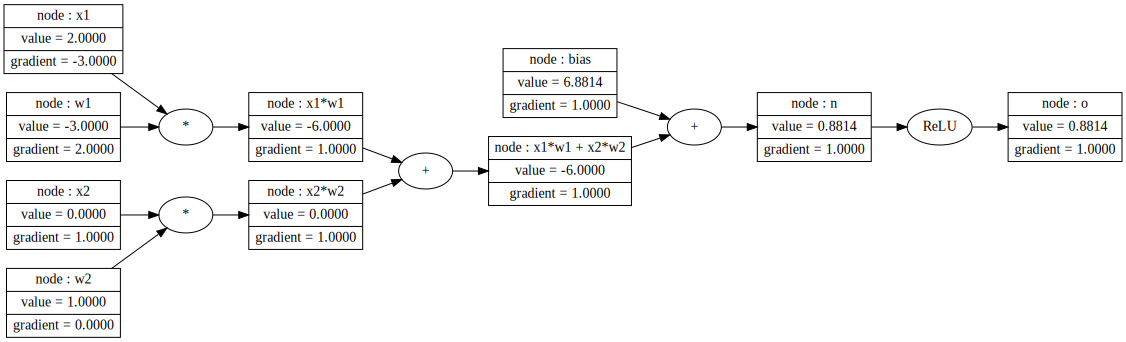

In [67]:
draw_dot(o)

# Double check with PyTorch

In [50]:
import torch

In [57]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

0.7071066904050358


In [60]:
# On fait un sanity check pour s'assurer que tout balance.
print('x2 :', x2.grad.item())
print('w2 :', w2.grad.item())
print('x1 :', x1.grad.item())
print('w1 :', w1.grad.item())
print('b  :',  b.grad.item())

x2 : 0.5000001283844369
w2 : 0.0
x1 : -1.5000003851533106
w1 : 1.0000002567688737
b  : 0.5000001283844369


## Building a Neural Net from scratch using only our Value object

### Creating a Neuron

In [14]:
import sys
# module_path = "/home/john-ubu/dev/minigrad"
module_path  ="C:\\Users\\mmonn\\Desktop\\torch\\pytorch_autrograd_reimplementation"
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
from src.utils import draw_dot, trace
from src.engine import Value
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
class Neuron():

    def __init__(self, in_dim):
        self.w = [Value(random.uniform(-1,1)) for _ in range(in_dim)]
        self.b = Value(0)

    def __call__(self, x):
        # w@x + b (voir img neuron plus haut)
        # act = sum([wi* xi for wi, xi in zip(self.w, x)]) + self.b
        # the previous line can be optimized for computational efficiency by starting our sum at our bias
        # dont forget to parenthisize the generator expression (wi*xi for wi, xi in zip(self.w,x))
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

In [16]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9926675772578061, grad=0)

### Creating a layer

In [17]:
class Layer:
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.neurons = [Neuron(in_dim) for _ in range(out_dim)]
        
    #TODO
    #Check avec emilio cmon __repr__ est ok si je veux : Layer(in_dim, out_dim) for each layer
    #Why? To be able to obtain layer sizes from the MLP
    def __repr__(self):
        for neuron in self.neurons:
            return f"Layer(in_dim={self.in_dim}, out_dim={self.out_dim})"
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # if outs contains a single item, return the value instead of a list object
        # otherwise return the list object
        return outs[0] if len(outs) == 1 else outs

In [18]:
# now we can create a layer, with 2 inputs (x1, x2) and three output neurons (h1, h2, h3)
# define our xs
x = [2.0, 3.0]

# define our layer with 3 output neurons
n = Layer(2, 3)
n(x)

[Value(data=0.7611009183402203, grad=0),
 Value(data=0.0046134477790205864, grad=0),
 Value(data=0.986614349704251, grad=0)]

### Creating a full MLP
Keep in mind that in an MLP, Neurons from Layers just feed into each other. So lets create that.

In [19]:
class MLP:
    def __init__(self, in_dim, out_dim):
        # out_dim is a list, so we essentially concatenate two lists 
        # that contain our layer dimensions
        sz = [in_dim] + out_dim
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(out_dim))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [20]:
x = [2.0, 3.0]
n = MLP(2, [4,4,1])
n(x)

Value(data=0.47235447228397065, grad=0)

In [21]:
n.layers

[Layer(in_dim=2, out_dim=4),
 Layer(in_dim=4, out_dim=4),
 Layer(in_dim=4, out_dim=1)]

In [22]:
# sanity check demo
in_dim = 2
layers_dim = [4, 4, 1]

sz = [in_dim] + layers_dim
print(f"What sz looks like : {sz}")
dummy_layer = [(sz[i], sz[i+1]) for i in range(len(layers_dim))]
print(dummy_layer)
        

What sz looks like : [2, 4, 4, 1]
[(2, 4), (4, 4), (4, 1)]


### Visualize computational graph for small MLP

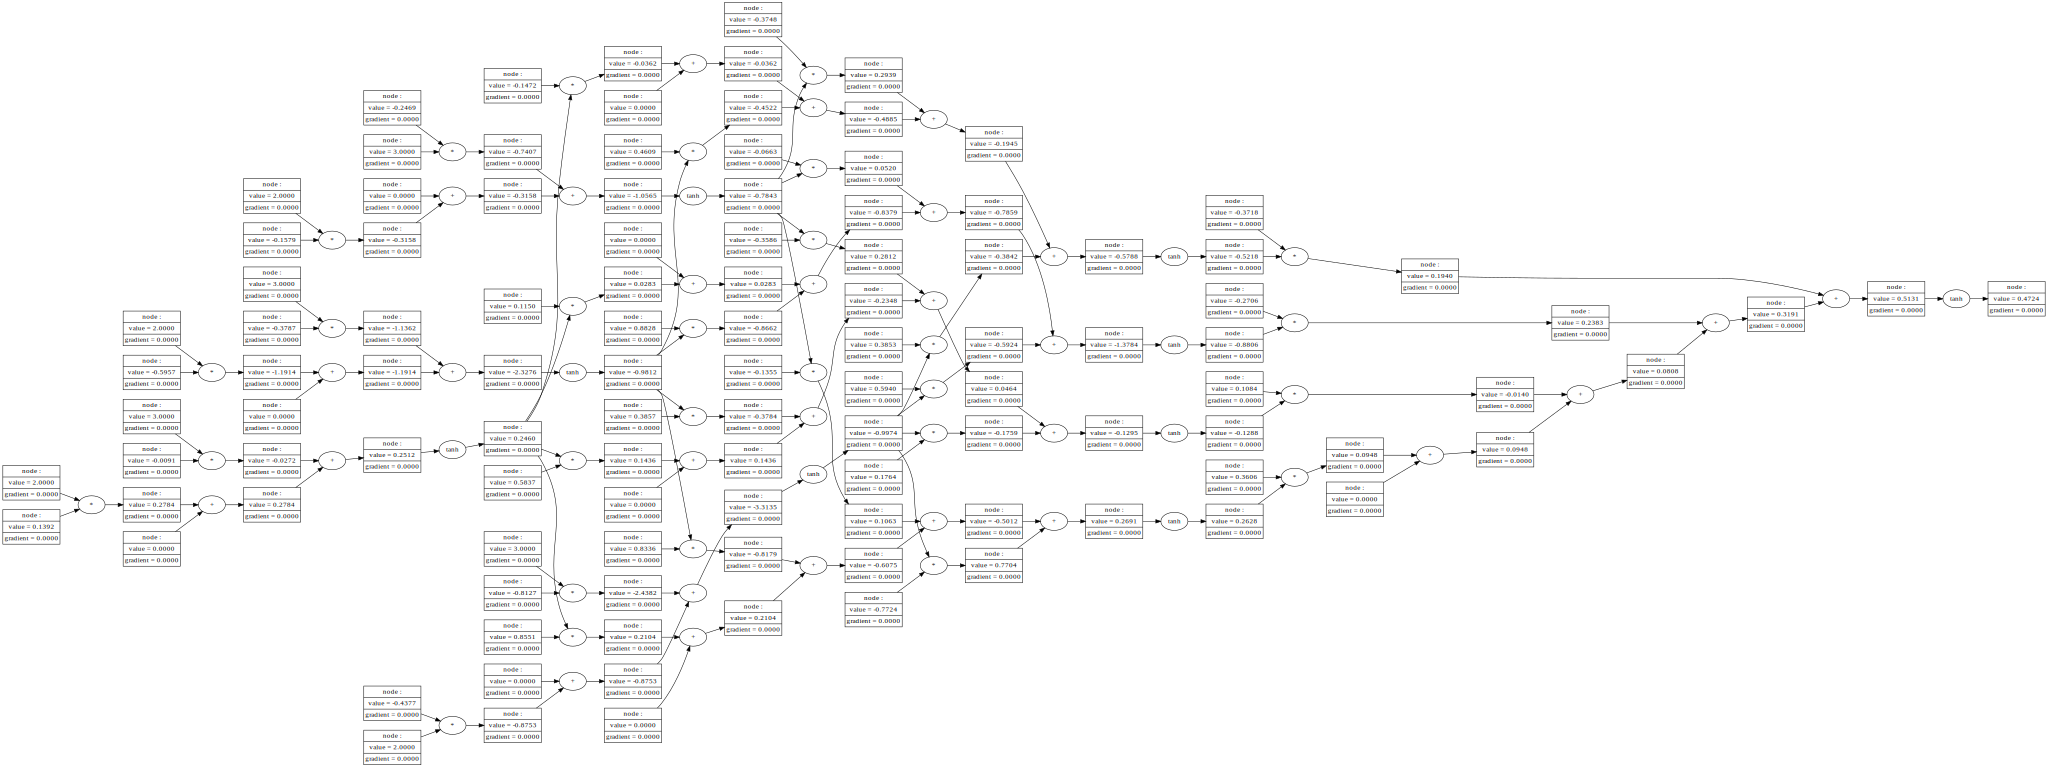

In [23]:
draw_dot(n(x))

# Binary Classification Toy Example

In [25]:
# define a small toy dataset
xs = [
    [2., 3., -1.],
    [3., -1., 0.5],
    [0.5, 1., 1.],
    [1., 1., -1.]
]

# define our targets
ys = [1., -1., -1., 1.]

# obtain model predictions
preds = [n(x) for x in xs]
preds

[Value(data=0.47235447228397065, grad=0),
 Value(data=0.36332501779174603, grad=0),
 Value(data=0.38788798508097794, grad=0),
 Value(data=0.4211254851011654, grad=0)]

### Defining our loss 
The loss essentially being our way of knowing how well our model is performing at it's task.

Let's start with the squared error

In [29]:
# ygt = y ground truth
# yout = our predicted output by the network
# We can see that our loss will equal 0 iif yout = ygt for every observation
loss = [(yout - ygt)**2 for ygt, yout in zip(ys, preds)]

In [30]:
loss

[Value(data=0.2784098029187271, grad=0),
 Value(data=1.8586551041368644, grad=0),
 Value(data=1.926233059132137, grad=0),
 Value(data=0.33509570399936106, grad=0)]

In [31]:
# We just obtained a list of errors for each observations
# However, we would like a single number that aggregates all losses i.e a sum.
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, preds)])
loss

Value(data=4.398393670187089, grad=0)

In [35]:
# Lets look at the gradient of for example the first variable of the first neuron of the first layer
print(f"The weight is : {n.layers[0].neurons[0].w[0].data}")
print(f"The gradient is : {n.layers[0].neurons[0].w[0].grad}, but don't panic, we havn't performed backprop yet!!")


The weight is : 0.13918961526129925
The gradient is : 0, but don't panic, we havn't performed backprop yet!!


In [36]:
# Let's do something magical!
loss.backward()

In [37]:
loss

Value(data=4.398393670187089, grad=1)

In [39]:
# Lets look at the gradient of for example the first variable of the first neuron of the first layer
print(f"The weight is : {n.layers[0].neurons[0].w[0].data}")
print(f"The gradient is : {n.layers[0].neurons[0].w[0].grad}, Wohoo!! We have a gradient!!")

The weight is : 0.13918961526129925
The gradient is : 1.8724996722744947, wohoo!! We have a gradient!!


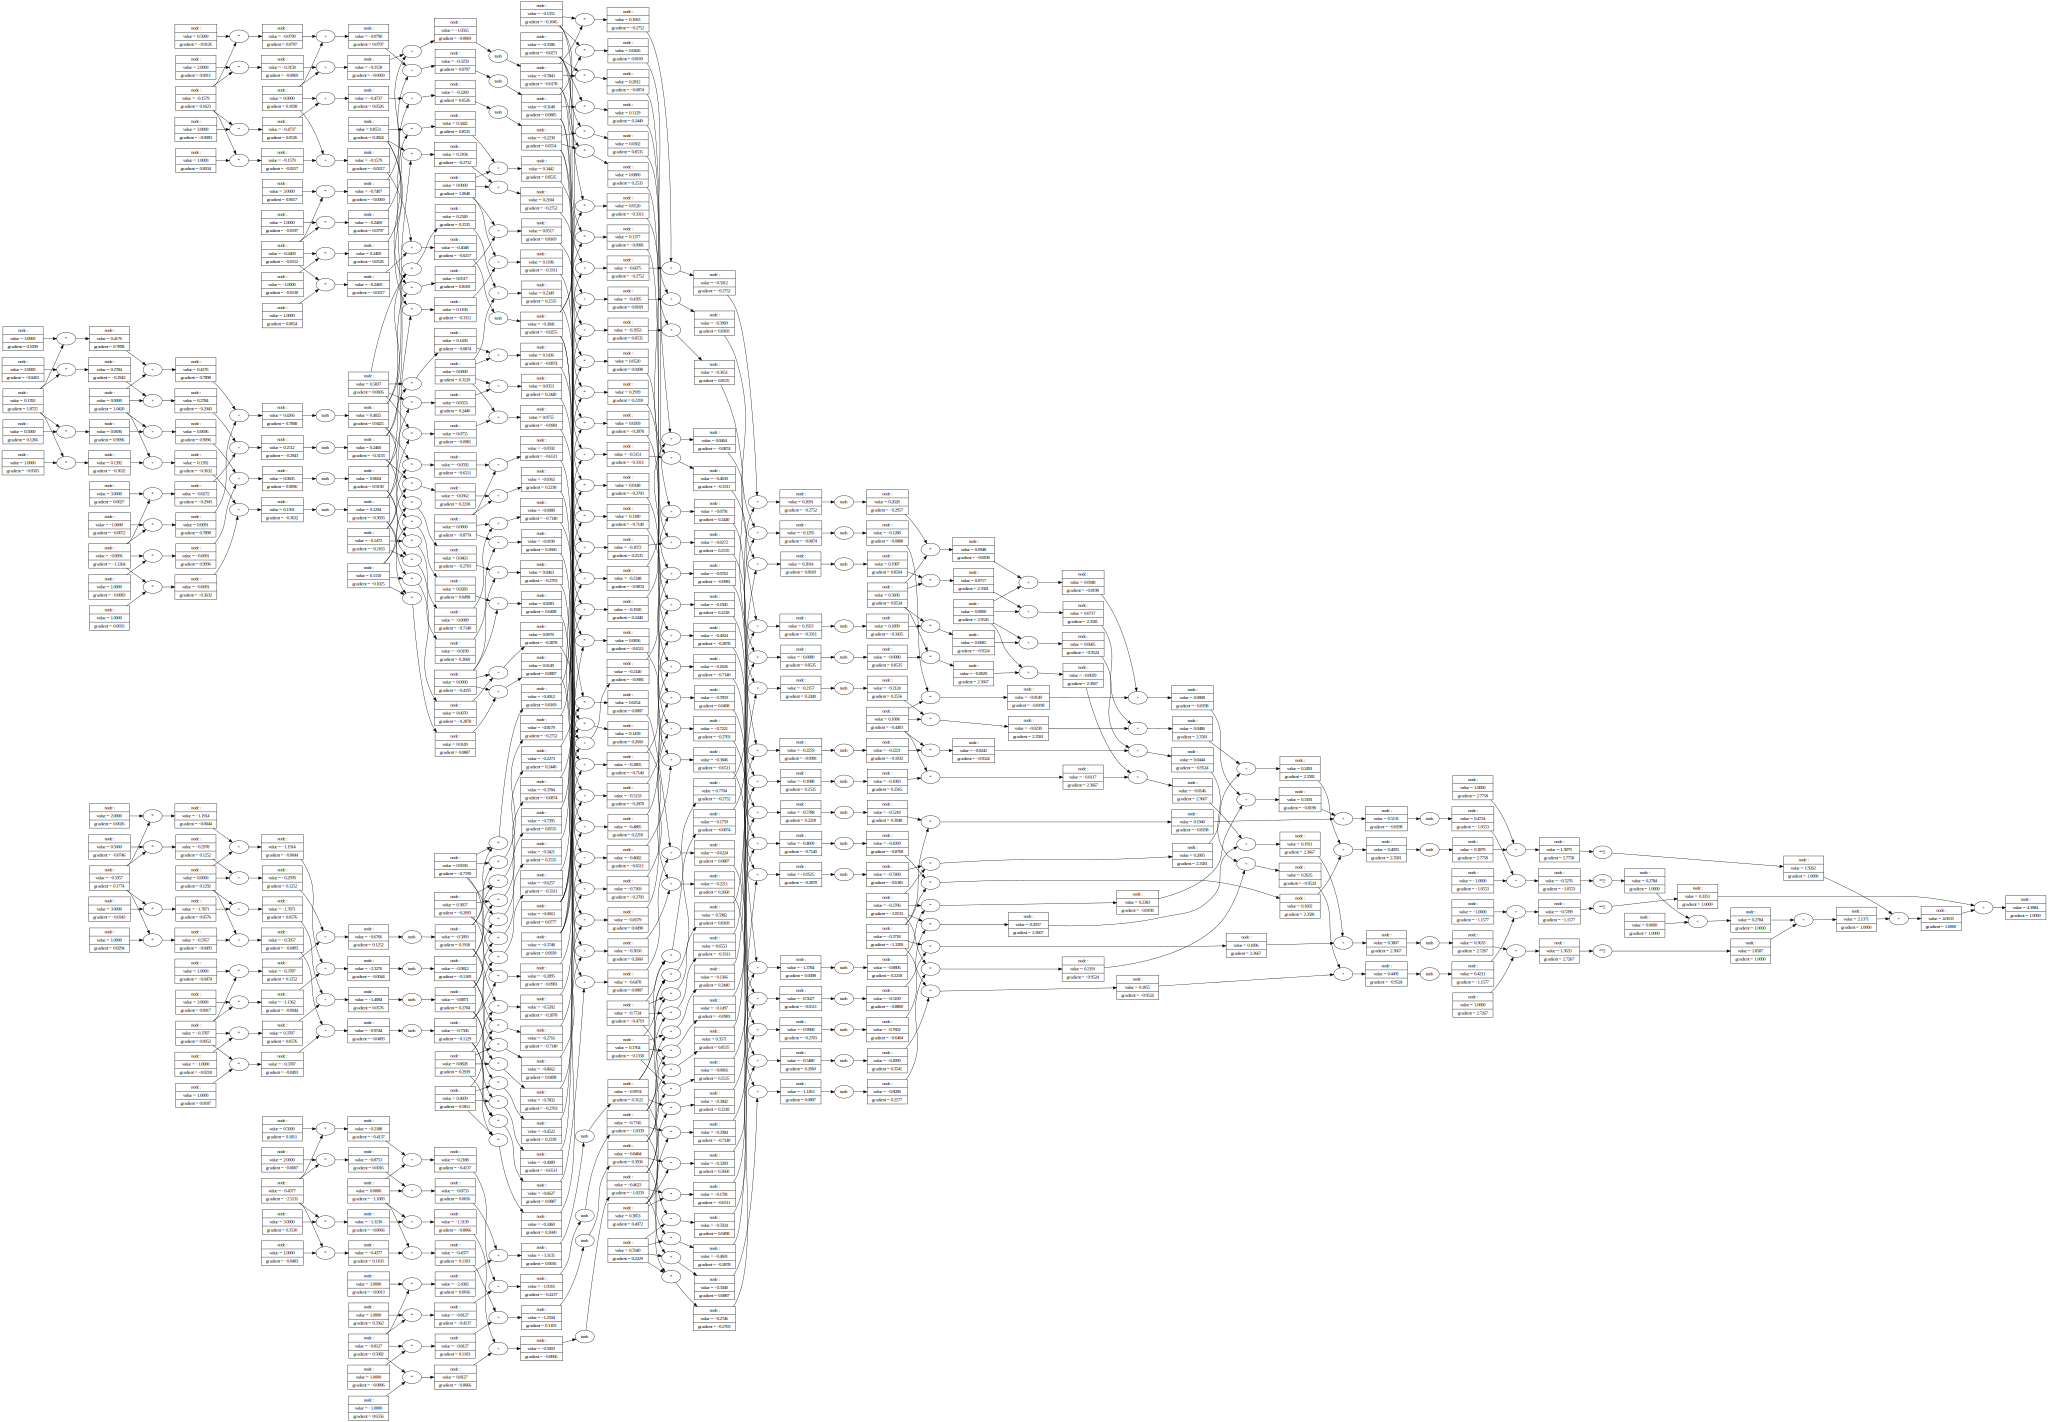

In [41]:
# Now lets have a laugh and look at the computational graph
draw_dot(loss)

# Why is it so big and messy?
# Remember we added the loss, did four forward pass, and a full backprop pass.
# Also keep in mind we are currently tracking the gradients of our features (xs)
# Which is completly useless because we cannot update the Xs, only the weights
# So we could (and should) only track the gradients of the weights

## Gathering all the parameters of our models pour pouvoir les update simultanement

In [20]:
class Neuron():

    def __init__(self, in_dim):
        self.w = [Value(random.uniform(-1,1)) for _ in range(in_dim)]
        self.b = Value(0)

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        # self.w est une liste, self.b ne l'est pas, et au final on
        # veut une liste de parametres, d'ou :
        return self.w + [self.b]

In [21]:
class Layer:
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.neurons = [Neuron(in_dim) for _ in range(out_dim)]
        
    def __repr__(self):
        for neuron in self.neurons:
            return f"Layer(in_dim={self.in_dim}, out_dim={self.out_dim})"
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # version detaille de cette listcomp presente juste en dessous
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
# Ci-dessous une version decortique de la methode parameters pour fin pedagogique
#     def parameters(self):
#         params = []
#         for neuron in self.neurons:
#             neuron_params = neuron.parameters()
#             # we want to extend the list au lieu de append pour garder
#             # une liste d'elements atomiques
#             params.extend(neuron_params)
        
#         return params
            
        

In [22]:
class MLP:
    def __init__(self, in_dim, out_dim):
        sz = [in_dim] + out_dim
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(out_dim))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [17]:
x = [2.0, 3.0, -1.]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.21271002501921996, grad=0)

In [18]:
# Can we see our parameters?
# On peut voir qu'on a 9 neurones au total, chaqun avec 3 inputs + bias (ce qui colle avec nos layers [4, 4, 1])
n.parameters()

[Value(data=-0.17171442603823484, grad=0),
 Value(data=-0.40759958125034634, grad=0),
 Value(data=0.6813768267623876, grad=0),
 Value(data=0, grad=0),
 Value(data=-0.09605500204604311, grad=0),
 Value(data=-0.12816501129966218, grad=0),
 Value(data=-0.7828503990431224, grad=0),
 Value(data=0, grad=0),
 Value(data=-0.4203577897301125, grad=0),
 Value(data=0.9248868282846006, grad=0),
 Value(data=0.2630607909406162, grad=0),
 Value(data=0, grad=0),
 Value(data=0.20628344252166175, grad=0),
 Value(data=0.5900486913179888, grad=0),
 Value(data=-0.4313724936132515, grad=0),
 Value(data=0, grad=0),
 Value(data=0.2631097933225115, grad=0),
 Value(data=-0.3646537173444486, grad=0),
 Value(data=0.8426506624277637, grad=0),
 Value(data=-0.45832243474520173, grad=0),
 Value(data=0, grad=0),
 Value(data=-0.626918951836648, grad=0),
 Value(data=0.38838214541295857, grad=0),
 Value(data=0.18813139273866097, grad=0),
 Value(data=-0.5618273580509032, grad=0),
 Value(data=0, grad=0),
 Value(data=0.2982

In [19]:
# Great, we can! But how many of them are there?
print(f"There are {len(n.parameters())} parameters in our MLP model.")

There are 41 parameters in our MLP model.


In [23]:
# define a small toy dataset
xs = [
    [2., 3., -1.],
    [3., -1., 0.5],
    [0.5, 1., 1.],
    [1., 1., -1.]
]

# define our targets
ys = [1., -1., -1., 1.]

# define model
n = MLP(3, [4,4,1])

# obtain model predictions
preds = [n(x) for x in xs]
preds

[Value(data=-0.1622497214862704, grad=0),
 Value(data=-0.8130960979764582, grad=0),
 Value(data=-0.40037006524738733, grad=0),
 Value(data=-0.0728956604375676, grad=0)]

In [24]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, preds)])
loss

Value(data=2.896418640523726, grad=0)

In [31]:
loss.backward()

In [32]:
loss

Value(data=2.896418640523726, grad=1)

## Updating our loss! (important)

In [1]:
# on ajuste nos weights en fonction des gradients obtenu (welcome to SGD!)
# for p in n.parameters():
#     p.data += 0.001 * p.grad

Arretons nous pour reflechir un instant. What are we doing here? On update nos parameters DANS LE SENSE du gradient. Mais que nous donne le gradient? Essentiellement la direction dans laquelle aller pour MAXIMISER la fonction en question. Notre fonction est la loss. Donc en faisant bouger les weights de nos parametres dans le sense des gradients, on MAXIMISE la loss (bad idea!).

Que faut-il faire pour MINIMISER la loss alors? We need to go in the reverse direction of the gradient, d'ou :

In [13]:
import sys
# module_path = "/home/john-ubu/dev/minigrad"
module_path  ="C:\\Users\\mmonn\\Desktop\\torch\\pytorch_autrograd_reimplementation"
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
from src.modules import MLP, Neuron, Layer
from src.utils import draw_dot, trace
from src.engine import Value
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
random.seed(1337)

In [15]:
# define a small toy dataset
xs = [
    [2., 3., -1.],
    [3., -1., 0.5],
    [0.5, 1., 1.],
    [1., 1., -1.]
]

# define our targets
ys = [1., -1., -1., 1.]

# define our model 
n = MLP(3, [4,4,1])

In [16]:
# obtain model predictions
preds_t0 = [n(x) for x in xs]
preds_t0_scalar = [n(x).data for x in xs]
preds_t0

[Value(data=0.2769134447057285, grad=0),
 Value(data=0.25277110714986856, grad=0),
 Value(data=-0.09610577479232578, grad=0),
 Value(data=0.5189558391370138, grad=0)]

In [17]:
loss_t0 = sum([(yout - ygt)**2 for ygt, yout in zip(ys, preds_t0)])
print(f"La loss total a t0 (c'est a dire APRES le premier FORWARD et AVANT le premier BACKWARD) : {loss_t0.data}")

La loss total a t0 (c'est a dire APRES le premier FORWARD et AVANT le premier BACKWARD) : 3.1407178684209995


In [18]:
print(f"BEFORE THE FIRST BACKWARD PASS : \n-------------")
print(f"The value of that particular weight is : {n.layers[0].neurons[0].w[0].data}")
print(f"The gradient of that particular weight is : {n.layers[0].neurons[0].w[0].grad}")
print(f"The ground truth value  for that observation is : {ys[0]}")
print(f"The total loss for our MLP model is : {loss_t0.data}")

BEFORE THE FIRST BACKWARD PASS : 
-------------
The value of that particular weight is : 0.23550571390294128
The gradient of that particular weight is : 0
The ground truth value  for that observation is : 1.0
The total loss for our MLP model is : 3.1407178684209995


In [19]:
# apply backwards on our loss to obtain first round of gradients for 
# the model to update its parameters with
# (exact same thing as in pytorch)
print(f"On applique notre premier backward...")
loss_t0.backward()

On applique notre premier backward...


In [20]:
# lets nudge all our parameters in the right direction (notice the - sign in front de notre learning rate)
# and see afterwards how our loss and weights have changed
# (equivalent to optim.step() in pytorch)
print(f"On UPDATE nos parametres (dans le sense INVERSE du gradient!! Important sinon on maximise la loss)")
for p in n.parameters():
    p.data += -0.01 * p.grad

On UPDATE nos parametres (dans le sense INVERSE du gradient!! Important sinon on maximise la loss)


In [21]:
# obtain model predictions
preds_t1 = [n(x) for x in xs]
preds_t1_scalar = [n(x).data for x in xs]

print(f"UPDATED preds AFTER the first BACKWARD pass :\n{preds_t1_scalar}\n------")

loss_t1 = sum([(yout - ygt)**2 for ygt, yout in zip(ys, preds_t1)])
print(f"UPDATED loss AFTER the first BACKWARD pass : {loss_t1.data}\n------")

# ys = [1., -1., -1., 1.]
print(f"The UPDATED value of that particular weight is : {n.layers[0].neurons[0].w[0].data}")
print(f"The UPDATED gradient of that particular weight is : {n.layers[0].neurons[0].w[0].grad}")
print(f"The ground truth value  for that observation is : {ys[0]}")
print(f"The UPDATED total loss for our MLP model is : {loss_t1.data}")

UPDATED preds AFTER the first BACKWARD pass :
[0.3250662300531927, 0.06850274448332833, -0.2990211659724091, 0.5295079260464919]
------
UPDATED loss AFTER the first BACKWARD pass : 2.309967826190769
------
The UPDATED value of that particular weight is : 0.2046764356296979
The UPDATED gradient of that particular weight is : 3.082927827324338
The ground truth value  for that observation is : 1.0
The UPDATED total loss for our MLP model is : 2.309967826190769


In [28]:
# Comparons le tout :
print(f"Ground truth : {ys}")
print(f"Preds t0 : {preds_t0_scalar}")
print(f"Preds t1 : {preds_t1_scalar}\n----------")
print(f"Loss at t0: {loss_t0.data}")
print(f"Loss at t1: {loss_t1.data}")
print(f"Did our loss diminish after one round of backprop? {'Yes' if loss_t1.data < loss_t0.data else 'No'}")

Ground truth : [1.0, -1.0, -1.0, 1.0]
Preds t0 : [0.2769134447057285, 0.25277110714986856, -0.09610577479232578, 0.5189558391370138]
Preds t1 : [0.3250662300531927, 0.06850274448332833, -0.2990211659724091, 0.5295079260464919]
----------
Loss at t0: 3.1407178684209995
Loss at t1: 2.309967826190769
Did our loss diminish after one round of backprop? Yes


On remarque que:
- nous avons obtenu le gradient grace a notre methode .backward()
- la valeur de ce poid en particulier a diminu (c'est ce qu'on veut: gradient positif et on va dans le sense INVERSE du gradient)
- Notre loss total a diminue (yay!), on passe de 3.14 (`t0`) versus 2.30 (`t1`) 
- Nos preds se rapproche tranquillement des valeurs que nous voulons qu'elles predisent (yay, SGD is working!)

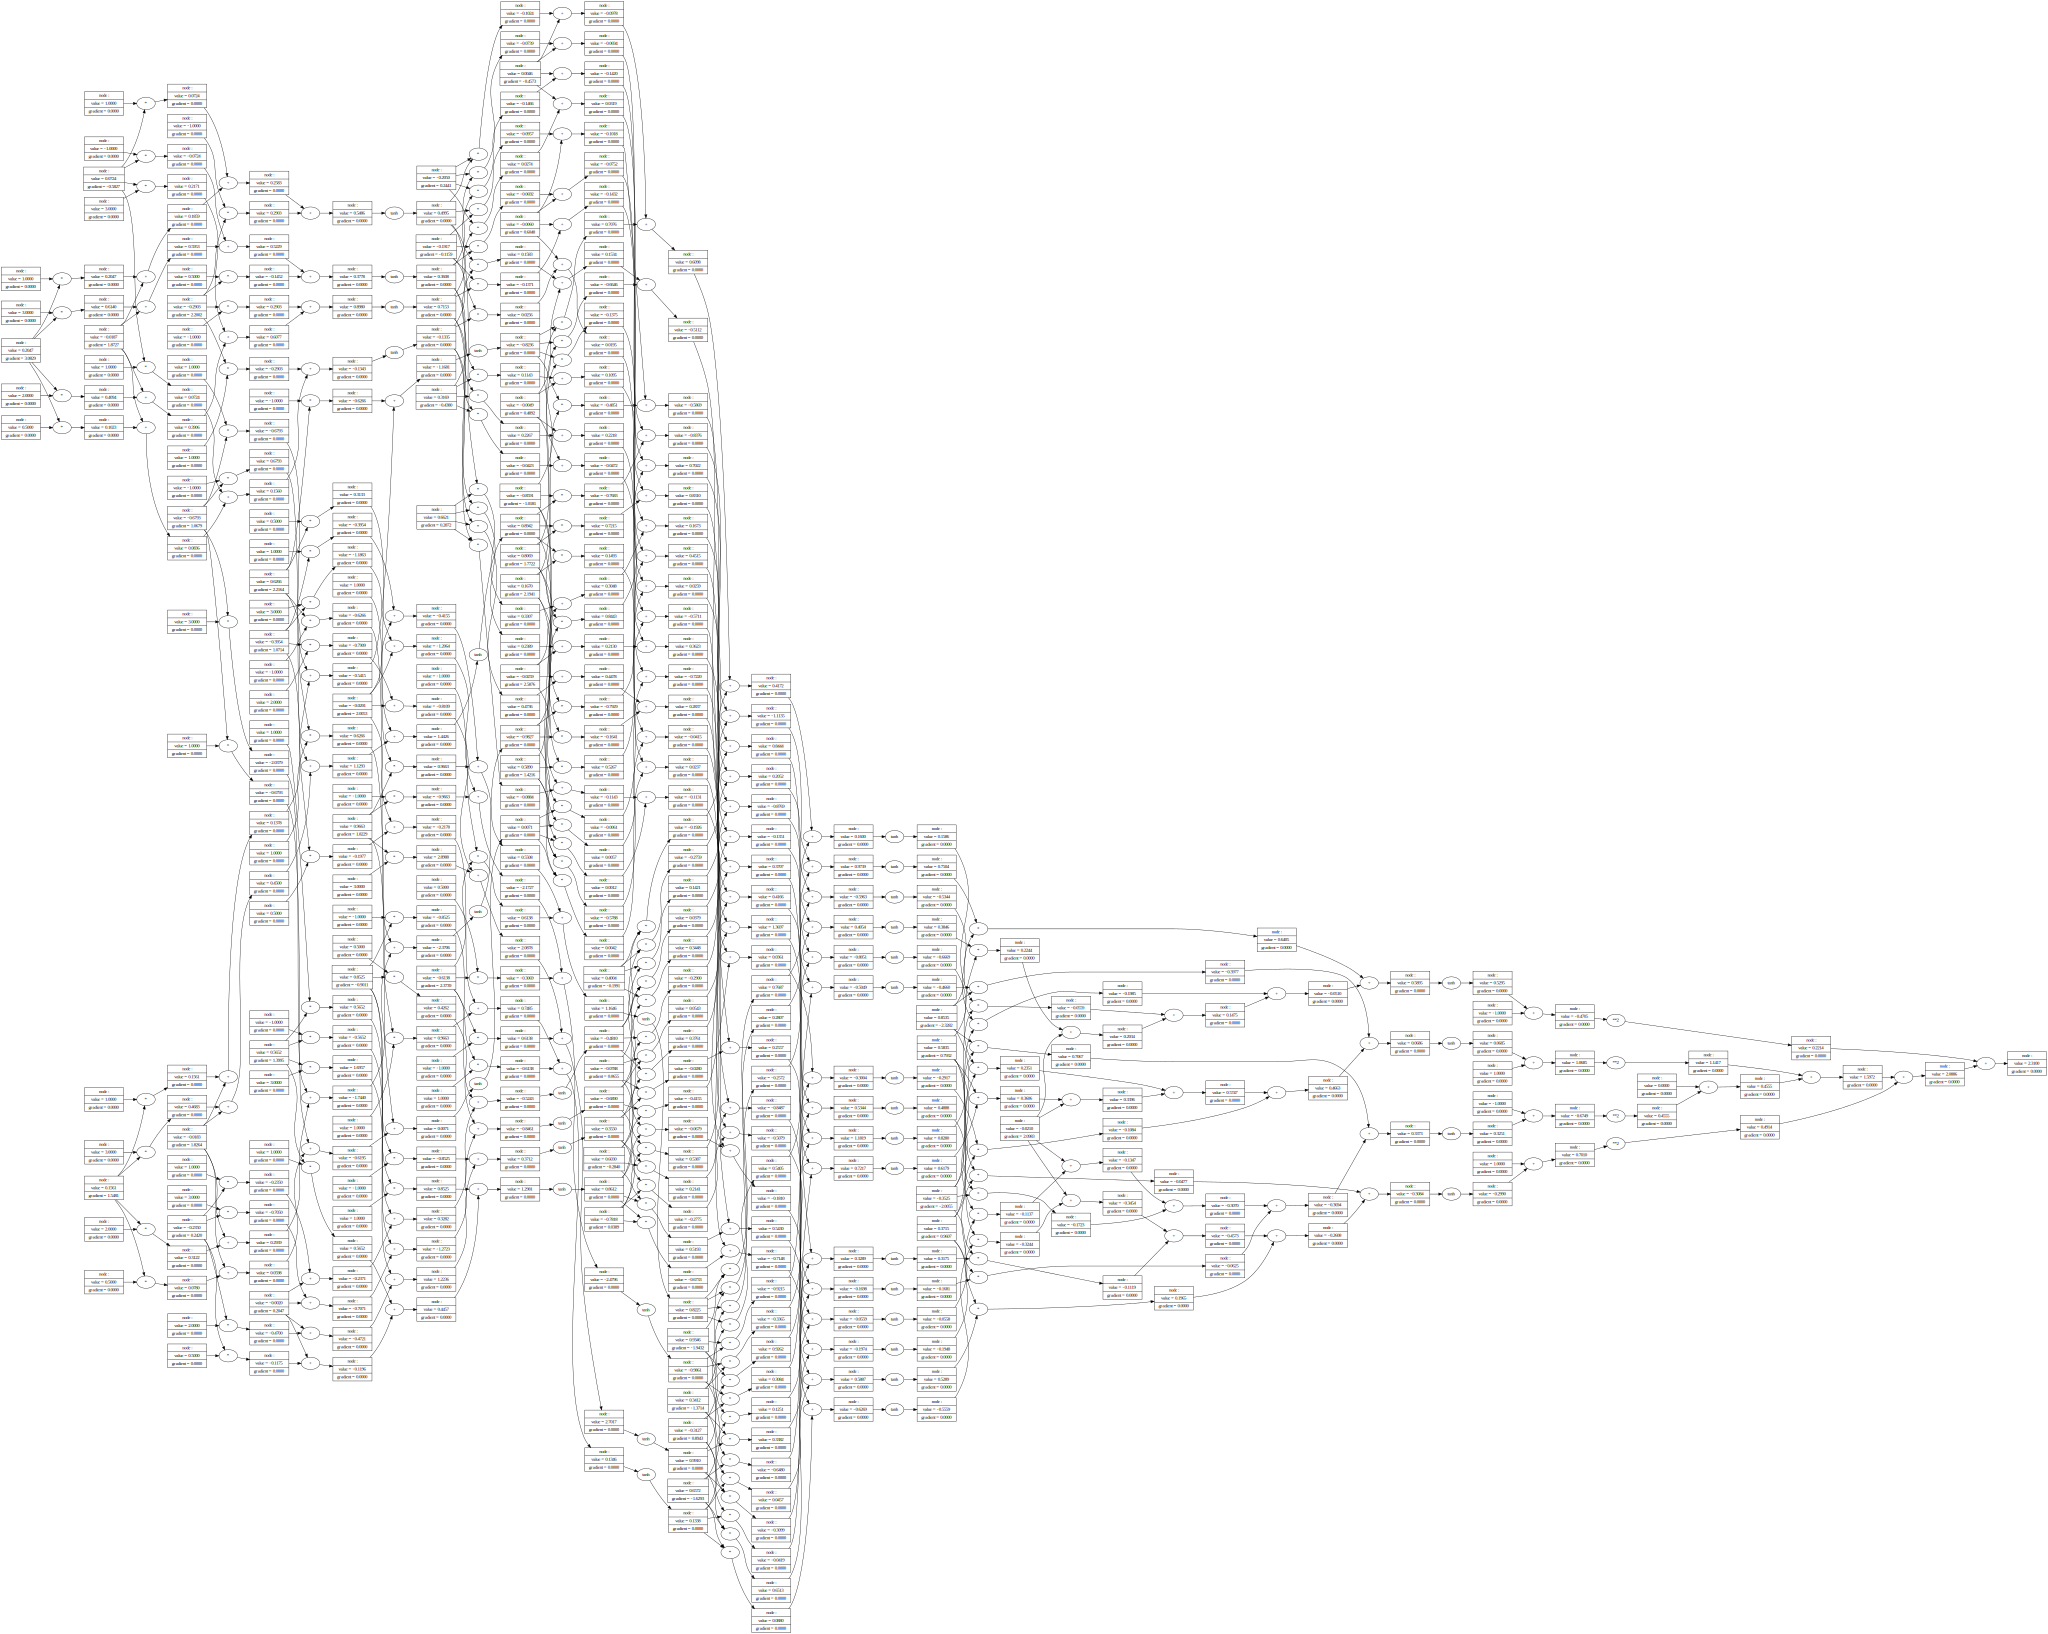

In [31]:
draw_dot(loss_t1)